In [1]:
# %load ../loaders/imports.py
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

from pyuoi.linear_model import UoI_Lasso
from pyuoi.linear_model.adaptive import (mBIC, eBIC, mBIC2, BIC, MIC, 
bayesian_log_ll, bayesian_lambda_selection, L1_bayes)

In [2]:
from sklearn.linear_model import lars_path

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from scipy.special import binom

In [5]:
# Just look at the different terms in the Bayes Factor and how they scale with (1) sparsity (2) model penalty (3) number of samples
n_features = 50
n_samples = np.array([200, 400, 800, 1600])

# Iterate over sparsity. Yield a sequences of models using LARS. Choose a model using the various extensions 
# of the BIC. 

sparsity = np.linspace(0.05, 1, 11)
sigma = gen_covariance(n_features, 0, n_features, 5, 1)

oracle_penalty = np.zeros((sparsity.size, n_samples.size))
MIC_oracle_sa = np.zeros((sparsity.size, n_samples.size))

bayesian_penalty = np.zeros((sparsity.size, n_samples.size))
bMIC_sa = np.zeros((sparsity.size, n_samples.size))

bayesian_penalty2 = np.zeros((sparsity.size, n_samples.size))
bMIC_sa2 = np.zeros((sparsity.size, n_samples.size))

# Oracle sa
sa = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))

np1 = 80

# All the different terms:
ll = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))
p1 = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))
# BIC = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))
RSS = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))
BIC2 = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))
BIC3 = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))
M_k = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))
P_M = np.empty((sparsity.size, n_samples.size), dtype =  np.dtype('O'))

for i, s in enumerate(sparsity):

    for ii, ns in enumerate(n_samples):
        
        t0 = time.time()
        
        penalties = np.linspace(0, 2 * np.log(ns), np1)
        
        beta = gen_beta2(n_features, n_features, sparsity = s, betawidth = 0)
        X, X_test, y, y_test, ss = gen_data(ns, n_features, kappa = 5, 
                                            covariance = sigma, beta = beta)

        X = StandardScaler().fit_transform(X)
        y -= np.mean(y)

        _, _, coefs  = lars_path(X, y.ravel(), method = 'lasso')
        
        supports = (coefs.T != 0).astype(bool)

        # Stick the true model in there
        # supports = np.vstack([supports, (beta.ravel() !=0).astype(bool)])

        sa[i, ii] = selection_accuracy(beta.ravel(), supports)

        # Fit OLS models to each of the supports
        models = []
        
        MIC_scores_ = np.zeros((supports.shape[0], np1))
        
        _ll = np.zeros(np1)
        _p1 = np.zeros(np1)
        _BIC = np.zeros(np1)
        _BIC2 = np.zeros(np1)
        _BIC3 = np.zeros(np1)
        _M_k = np.zeros(np1)
        _P_M = np.zeros(np1)
                
        exec_times = np.zeros(supports.shape[0])
        
        for j in range(supports.shape[0]):
            t1 = time.time()

            support = supports[j, :]
            if np.count_nonzero(1 * support > 0):
                model = LinearRegression().fit(X[:, support] , y)
                models.append(model)        
                y_pred = model.predict(X[:, support])
            else:
                models.append(np.nan)
                y_pred = np.zeros(y.size)

            MIC_scores_[j, :] =  np.array([MIC(y.ravel(), y_pred.ravel(), 
                                           np.count_nonzero(1 * support), penalty) 
                                           for penalty in penalties])
            
            exec_times[j] = time.time() - t1

        selected_models = np.argmin(MIC_scores_, axis = 0)

        bayes_factors = np.zeros(np1)
        bayes_factors2 = np.zeros(np1)
        
        for i3, penalty in enumerate(penalties):
            
            support = supports[selected_models[i3], :]
            yy = models[selected_models[i3]].predict(X[:, support])
            # Record all Bayesian terms for each penalty
            ll_, p1_, BIC_, BIC2_, BIC3_, M_k_, P_M_ = bayesian_lambda_selection(
                                                       y, yy, n_features, np.count_nonzero(1 * support),
                                                       s, penalty)

            # Add things up appropriately
            bayes_factors[i3] = 2 * ll_ - BIC_ - BIC2_ + BIC3_ - p1_ + P_M_
            
            _ll[i3] = ll_
            _p1[i3] = p1_
            _BIC[i3] = BIC_
            _BIC2[i3] = BIC2_
            _BIC3[i3] = BIC3_
            _M_k[i3] = M_k_
            _P_M[i3] = P_M_

        # Select the penalty based on the highest bayes factors 
        bidx = np.argmax(bayes_factors)
        bidx2 = np.argmax(bayes_factors2)
        
        # Save the penalty strength and the chosen model
        bayesian_penalty[i, ii] = penalties[bidx]
        
        # For MIC scores, record the oracle selection accuracy and the oracle penalty
        MIC_selection_accuracies = [selection_accuracy(beta.ravel(), 
                                    supports[selected_models[j], :]) 
                                    for j in range(selected_models.size)]
        
        # For MIC scores, record the oracle selection accuracy and the orcale penalty 

        oracle_penalty[i, ii] = penalties[np.argmax(MIC_selection_accuracies)]
        MIC_oracle_sa[i, ii] = np.max(MIC_selection_accuracies)    
        bMIC_sa[i, ii] = MIC_selection_accuracies[bidx]
        
        ll[i, ii] = _ll
        p1[i, ii] = _p1
#         BIC[i, ii] = _BIC
        BIC2[i, ii] = _BIC2
        BIC3[i, ii] = _BIC3
        M_k[i, ii] = _M_k
        P_M[i, ii] = _P_M
        
        print(time.time() - t0)

0.15312433242797852
0.13167023658752441
0.1575794219970703
0.1835927963256836
0.1461200714111328
0.14212846755981445
0.19448018074035645
0.18650102615356445
0.14165544509887695
0.13065028190612793
0.16122651100158691
0.18007254600524902
0.13717198371887207
0.12820076942443848
0.1815495491027832
0.18248271942138672
0.1431276798248291
0.1489100456237793
0.16655254364013672
0.20545148849487305
0.1406252384185791
0.15459370613098145
0.14412903785705566
0.19399261474609375
0.14464259147644043
0.14757776260375977
0.2368779182434082
0.3820033073425293
0.2184154987335205
0.15754318237304688
0.18051767349243164
0.3061854839324951
0.19730186462402344
0.20448613166809082
0.17649626731872559
0.2498159408569336
0.16205835342407227
0.19388747215270996
0.19448065757751465
0.21045327186584473
0.2513465881347656
0.1574239730834961
0.17955541610717773
0.1986856460571289


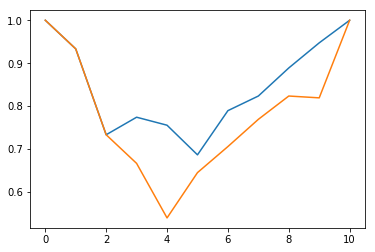

In [6]:
plt.plot(MIC_oracle_sa[:, 0])
plt.plot(bMIC_sa[:, 0])

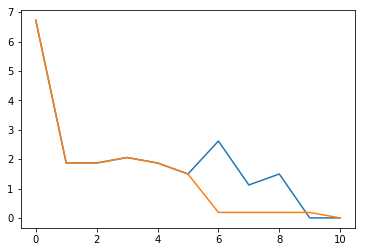

In [7]:
plt.plot(oracle_penalty[:, 3])
plt.plot(bayesian_penalty[:, 3])

In [5]:
from sklearn.model_selection import train_test_split

In [8]:
from pyuoi import utils

In [10]:
# Looks promising - How about sparsity estimation? 

# Just look at the different terms in the Bayes Factor and how they scale with (1) sparsity (2) model penalty (3) number of samples
n_features = 50
n_samples = np.array([200, 400])

# Iterate over sparsity. Yield a sequences of models using LARS. Choose a model using the various extensions 
# of the BIC. 

sparsity = np.linspace(0.05, 1, 11)
sigma = gen_covariance(n_features, 0, n_features, 5, 1)

n_boots = 48
train_frac = 0.75

sparsity_estimates = np.zeros((sparsity.size, len(n_samples), n_boots))
sparsity_estimates2 = np.zeros((sparsity.size, len(n_samples), n_boots))
sparsity_estimates3 = np.zeros((sparsity.size, len(n_samples), n_boots))

# Initialize the sparsity estimate with BIC on LARS paths on bootstraps
for i, s in enumerate(sparsity):

    for ii, ns in enumerate(n_samples):
        
        t0 = time.time()
                
        beta = gen_beta2(n_features, n_features, sparsity = s, betawidth = 0)
        X, X_test, y, y_test, ss = gen_data(ns, n_features, kappa = 5, 
                                            covariance = sigma, beta = beta)

                
        for boot in range(n_boots):
            # Draw bootstraps
            idxs_train, idxs_test = train_test_split(np.arange(X.shape[0]), 
                                                     train_size = train_frac,
                                                     test_size = 1 - train_frac)
            Xb = X[idxs_train]
            yb = y[idxs_train]

            Xb = StandardScaler().fit_transform(Xb)
            yb -= np.mean(yb)
    
            alphas, _, coefs  = lars_path(Xb, yb.ravel(), method = 'lasso')
                            
            y_pred = Xb @ coefs
                    
            # Assess BIC on the LARS path to estimate the sparsity. 
            BIC_scores = np.array([MIC(yb.ravel(), y_pred[:, j].ravel(),
                                       np.count_nonzero(coefs[:, j]), np.log(ns)) 
                                   for j in range(coefs.shape[1])])  

            # Use a penalized likelihood Bayes factor on with the corresponding
            # penalty
            BIC_scores3 = np.array([L1_bayes(yb.ravel(), y_pred[:, j].ravel(),
                                             coefs[:, j], alphas[j]) 
                                    for j in range(coefs.shape[1])])

            # Compare with using OLS estimates fit to the supports
            supports = (coefs.T != 0).astype(bool)

            BIC_scores2 = np.zeros(supports.shape[0])

            for j in range(supports.shape[0]):

                support = supports[j, :]
                if np.count_nonzero(1 * support > 0):
                    model = LinearRegression().fit(Xb[:, support] , yb)      
                    y_pred = model.predict(Xb[:, support])
                else:
                    y_pred = np.zeros(yb.size)
                
                BIC_scores2[j] = MIC(yb.ravel(), y_pred.ravel(),
                                     np.count_nonzero(1 * support), np.log(ns))
    
            sparsity_estimates[i, ii, boot] = float(np.count_nonzero(
                                    coefs[:, np.argmin(BIC_scores)]))/float(n_features)
            sparsity_estimates2[i, ii, boot] = float(np.count_nonzero(
                                    coefs[:, np.argmin(BIC_scores2)]))/float(n_features)
            sparsity_estimates3[i, ii, boot] = float(np.count_nonzero(
                                    coefs[:, np.argmax(BIC_scores3)]))/float(n_features)
        print(time.time() - t0)

4.227481126785278
3.1090056896209717
3.629021644592285
2.657768487930298
2.7777998447418213
3.2209596633911133
2.8459110260009766
2.7011313438415527
4.558057069778442
4.777089595794678
4.375053405761719
3.9955389499664307
4.197229623794556
2.9070303440093994
4.007694721221924
3.244015693664551
3.5739049911499023
3.82670521736145
3.3104448318481445
3.1830265522003174
4.177778720855713
4.490676403045654


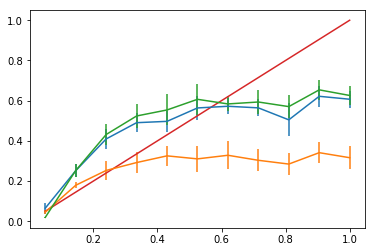

In [12]:
plt.errorbar(sparsity, np.mean(sparsity_estimates[:, 0, :], axis = 1),
             yerr = np.std(sparsity_estimates[:, 0, :], axis = 1))
plt.errorbar(sparsity, np.mean(sparsity_estimates2[:, 0, :], axis = 1),
             yerr = np.std(sparsity_estimates2[:, 0, :], axis = 1))
plt.errorbar(sparsity, np.mean(sparsity_estimates3[:, 0, :], axis = 1),
             yerr = np.std(sparsity_estimates3[:, 0, :], axis = 1))
plt.plot(sparsity, sparsity)

In [10]:
# Roll with it!

# Full procedure: 
# --> Sparsity Estimation with bootstrapping
# --> Across a second stage of bootstraps - Optimal lambda selection via Bayesian procedure
# --> Select best models and bag

n_features = 50
ns = 200
sparsity = np.linspace(0.05, 1, 11)
sigma = gen_covariance(n_features, 0, n_features, 5, 1)

n_boots = 48
train_frac = 0.75

np1 = 100
penalties = np.linspace(0, 2 * np.log(ns), np1)

# Things to be recorded:
sparsity_estimates = np.zeros((sparsity.size, n_boots))
bayesian_penalty = np.zeros((sparsity.size, n_boots))
oracle_penalty = np.zeros((sparsity.size, n_boots))
MIC_oracle_sa_ = np.zeros((sparsity.size, n_boots))
bMIC_sa_ = np.zeros((sparsity.size, n_boots))
MIC_oracle_sa = np.zeros(sparsity.size)
bMIC_sa = np.zeros(sparsity.size)

final_bayes_estimates = np.zeros((sparsity.size, n_features))
final_oracle_estimates = np.zeros((sparsity.size, n_features))

for i, s in enumerate(sparsity):

    t0 = time.time()


    beta = gen_beta2(n_features, n_features, sparsity = s, betawidth = 0)
    X, X_test, y, y_test, ss = gen_data(ns, n_features, kappa = 5, 
                                        covariance = sigma, beta = beta)

    
    ######################### STEP 1: SPARSITY ESTIMATION #######################
        
    for boot in range(n_boots):
        # Draw bootstraps
        idxs_train, idxs_test = train_test_split(np.arange(X.shape[0]), 
                                                 train_size = train_frac,
                                                 test_size = 1 - train_frac)
        Xb = X[idxs_train]
        yb = y[idxs_train]

        Xb = StandardScaler().fit_transform(Xb)
        yb -= np.mean(yb)

        alphas, _, coefs  = lars_path(Xb, yb.ravel(), method = 'lasso')

        y_pred = Xb @ coefs

        # Assess BIC on the LARS path to estimate the sparsity. 
        BIC_scores = np.array([MIC(yb.ravel(), y_pred[:, j].ravel(),
                                   np.count_nonzero(coefs[:, j]), np.log(ns)) 
                               for j in range(coefs.shape[1])])  
        
        sparsity_estimates[i, boot] = float(np.count_nonzero(
                            coefs[:, np.argmin(BIC_scores)]))/float(n_features)

    ########################### STEP 2 : Determination of L0 Penalty ################
    
    estimates = np.zeros((n_boots, n_features))
    oracle_estimates = np.zeros((n_boots, n_features))
    
    for boot in range(n_boots):
        # Draw bootstraps
        idxs_train, idxs_test = train_test_split(np.arange(X.shape[0]), 
                                                 train_size = train_frac,
                                                 test_size = 1 - train_frac)
        Xb = X[idxs_train]
        yb = y[idxs_train]

        Xb = StandardScaler().fit_transform(Xb)
        yb -= np.mean(yb)

        alphas, _, coefs  = lars_path(Xb, yb.ravel(), method = 'lasso')

        supports = (coefs.T != 0).astype(bool)

        # Stick the true model in there
        # supports = np.vstack([supports, (beta.ravel() !=0).astype(bool)])

        sa = selection_accuracy(beta.ravel(), supports)
        # Keep track of oracle performance
        MIC_scores_ = np.zeros((supports.shape[0], np1))

        boot_estimates = np.zeros((supports.shape[0], n_features))
                
        models = []
        
        for j in range(supports.shape[0]):
            
            support = supports[j, :]

            if np.count_nonzero(1 * support > 0):
                model = LinearRegression().fit(X[:, support] , y)
                boot_estimates[j, support] = model.coef_.ravel()
                y_pred = model.predict(X[:, support])
                models.append(model)
            else:
                y_pred = np.zeros(y.size)
                models.append(np.nan)
            MIC_scores_[j, :] =  np.array([MIC(y.ravel(), y_pred.ravel(), 
                                           np.count_nonzero(1 * support), penalty) 
                                           for penalty in penalties])

        selected_models = np.argmin(MIC_scores_, axis = 0)

        bayes_factors = np.zeros(np1)

        for i3, penalty in enumerate(penalties):

            support = supports[selected_models[i3], :]
            yy = models[selected_models[i3]].predict(X[:, support])

            ll_, p1_, BIC_, BIC2_, BIC3_, M_k_, P_M_ = bayesian_lambda_selection(
                                                       y, yy, n_features, 
                                                       np.count_nonzero(1 * support),
                                                       sparsity_estimates[i, :], penalty)

            # Add things up appropriately
            bayes_factors[i3] = 2 * ll_ - BIC_ - BIC2_ + BIC3_ - p1_ + P_M_


        # Select the penalty based on the highest bayes factors 
        bidx = np.argmax(bayes_factors)

        # Save the penalty strength and the chosen model
        bayesian_penalty[i, boot] = penalties[bidx]

        # For MIC scores, record the oracle selection accuracy and the oracle penalty
        MIC_selection_accuracies = [selection_accuracy(beta.ravel(), 
                                    supports[selected_models[j], :]) 
                                    for j in range(selected_models.size)]

        # For MIC scores, record the oracle selection accuracy and the orcale penalty 

        oracle_penalty[i, boot] = penalties[np.argmax(MIC_selection_accuracies)]
        MIC_oracle_sa_[i, boot] = np.max(MIC_selection_accuracies)    
        bMIC_sa_[i, boot] = MIC_selection_accuracies[bidx]
        
        # Record the best estimate on this bootstrap as determined by the oracle
        # and by our procedure
        estimates[boot, :] = boot_estimates[selected_models[bidx], :]
        oracle_estimates[boot, :] = \
        boot_estimates[selected_models[np.argmax(MIC_selection_accuracies)], :]

    # Take the median and record final selection accuracies
    final_bayes_estimates[i, :] = np.median(estimates, axis = 0)
    final_oracle_estimates[i, :] = np.median(oracle_estimates, axis = 0)
    
    MIC_oracle_sa[i] = selection_accuracy(beta.ravel(), final_oracle_estimates[i, :].ravel())
    bMIC_sa[i] = selection_accuracy(beta.ravel(), final_bayes_estimates[i, :].ravel())
    
    print(time.time() - t0)

11.829089403152466
13.021472215652466
12.15297818183899
10.838577270507812
10.071763753890991
9.753331661224365
10.089123487472534
10.78699517250061
11.748738765716553
14.15234923362732
19.68026328086853


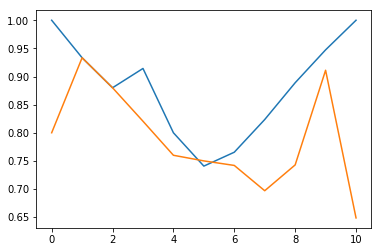

In [12]:
plt.plot(MIC_oracle_sa)
plt.plot(bMIC_sa)